# NLP project


Project 21: Automatic Summarization  

We shall consider structured document containing a title, abstract and a set of subsections. We would like to build a text summarizer such that tracks important keywords in the document. For this purpose, the first step is identify these keywords.  

In [ ]:
pip install --upgrade pip

In [ ]:
!pip list

In [1]:
# pip install nltk
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Markus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## TASK 1
Assume the initial input is given as html document (choose an example of your own), we hypothesize that important keywords are initially contained in the words of titles, abstract and possibly titles of subsections of the document. Suggest a simple python script that inputs an html document and outputs the lists of words in the title, abstract and title of section/subsections.

In [2]:
from bs4 import BeautifulSoup
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from nltk.tokenize import sent_tokenize
import time
# pip install -U selenium
# pip install webdriver-manager

# Collect title, subtitles, abstract and body text from html file.
# Print out titles and abstract and construct one string based on
# the elements.

def _convertHtmlToStr(elements):
    str = ""
    for element in elements:
        # Do not add if len is 1
        if len(element.text.split()) > 1:
            str += element.text
            if not str.endswith("."):
                str += "."
            str += " "
    sentences = sent_tokenize(str)
    return str, len(sentences)

def scrape_article(url):
    article = ""
    driver = webdriver.Chrome(ChromeDriverManager().install())
    driver.get(url)

    # Wait for article to fully load
    time.sleep(3)

    soup = BeautifulSoup(driver.page_source, 'lxml')
    strElement = ""
    countTitle, countAbstract, countH2, countH3, countH4, countP = 0, 0, 0, 0, 0, 0

    strElement, countTitle = _convertHtmlToStr(soup.find("h1", {"class": "document-title"}))
    print("Title:\n{}\n\n".format(strElement))
    article += strElement
    article += ". "
    strElement, countAbstract = _convertHtmlToStr(soup.find("div", {"class": "abstract-text"}))
    print("Abstract:\n{}\n\n".format(strElement))
    article += strElement

    articleHtmlBody = soup.find("div", {"id": "article"})
    if articleHtmlBody == None:
        raise ValueError

    strElement, countH2 = _convertHtmlToStr(articleHtmlBody.find_all("h2"))
    print("Section titles:\n{}\n\n".format(strElement))
    article += strElement
    strElement, countH3 = _convertHtmlToStr(articleHtmlBody.find_all("h3"))
    print("Subsection titles:\n{}\n\n".format(strElement))
    article += strElement
    strElement, countH4 = _convertHtmlToStr(articleHtmlBody.find_all("h4"))
    print("Subsubsection titles:\n{}\n\n".format(strElement))
    article += strElement
    strElement, countP = _convertHtmlToStr(articleHtmlBody.find_all("p"))
    article += strElement
    countP += 1

    driver.close()

    counts = [countTitle, countAbstract, countH2, countH3, countH4, countP]
    return article, counts

# Example article
url = "https://ieeexplore.ieee.org/document/6809191"
article, counts = scrape_article(url)

[WDM] - 

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 95.0.4638
[WDM] - Get LATEST driver version for 95.0.4638
[WDM] - Driver [C:\Users\Markus\.wdm\drivers\chromedriver\win32\95.0.4638.54\chromedriver.exe] found in cache
C:\Users\Markus\anaconda3\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: executable_path has been deprecated, please pass in a Service object


Title:
Scalable Nearest Neighbor Algorithms for High Dimensional Data. 


Abstract:
 Abstract:For many computer vision and machine learning problems, large training sets are key for good performance. However, the most computationally expensive part of many computer vision and machine learning algorithms consists of finding nearest neighbor matches to high dimensional vectors that represent the training data. We propose new algorithms for approximate nearest neighbor matching and evaluate and compare them with previous algorithms. For matching high dimensional features, we find two algorithms to be the most efficient: the randomized k-d forest and a new algorithm proposed in this paper, the priority search k-means tree. We also propose a new algorithm for matching binary features by searching multiple hierarchical clustering trees and show it outperforms methods typically used in the literature. We show that the optimal nearest neighbor algorithm and its parameters depend on the data se

In [3]:
import yake

In [4]:
# Not asked in task
# Keyword search and analysis by tesking yake library

w_extractor = yake.KeywordExtractor()

language = "en"
max_ngram_size = 2
deduplication_threshold = 0.9
numOfKeywords = 50 #alunperin 10

custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, top=numOfKeywords, features=None)
keywords = custom_kw_extractor.extract_keywords(article)


## TASK 2
Write down a simple python script that allows you to output the histogram of word frequency in the document, excluding the stopwords (see examples in online NLTK book). Use SpaCy named-entity tagger to identify person-named entities and organization-named entities in the document.

In [5]:
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np
from nltk.tokenize import word_tokenize
from collections import Counter

all_stopwords = stopwords.words('english')
all_stopwords.append('The')

In [6]:
text_tokens = word_tokenize(article)
tokens_without_sw = [word for word in text_tokens if word.isalpha() and word not in all_stopwords]
#print(filtered_sentence)

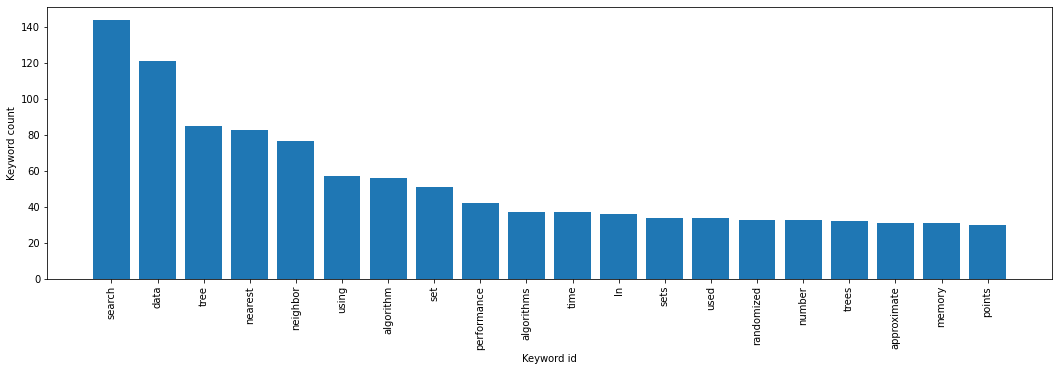

In [7]:

### Count histogram from every word manually ###
wordCounts = Counter(tokens_without_sw)
wordCounts = wordCounts.most_common()

wordCounts = wordCounts[0:20]

words = list(zip(*wordCounts))[0]
occurency = list(zip(*wordCounts))[1]
fig, ax = plt.subplots(figsize=(18,5))
plt.bar(np.arange(len(words)), occurency, align='center')
plt.xticks(np.arange(len(words)), words, rotation='vertical')
plt.ylabel('Keyword count')
plt.xlabel('Keyword id')
plt.show()

In [8]:
# Use SpaCy to identify person-named entities and organization-named entities
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm

# Identifying person and organization-named entities
wordsInStr = ""
for word in tokens_without_sw:
    wordsInStr += word
    wordsInStr += " "
    
nlp = en_core_web_sm.load()
doc = nlp(wordsInStr)

# Print only ORG or PERSON labeled entities
if doc.ents:
    for ent in doc.ents:
        if ent.label_ == "ORG" or ent.label_ == "PERSON":
            print(ent.text+ " - " + ent.label_)
else:
    print("No named entities found.")

NCC - ORG
NN - ORG
NN - ORG
KNN - ORG
RNN - ORG
KNN - ORG
P K View Source KNN - ORG
RKNN - ORG
RKNN - ORG
Variations - ORG
Leibe - PERSON
Schindler - PERSON
Jégou - PERSON
Babenko Lempitsky - PERSON
LSH - ORG
Variants LSH LSH - ORG
LSH Forest - ORG
LSH - ORG
Nearest - ORG
Wang - PERSON
Bawa - PERSON
LSH Forest - ORG
downhill simplex - PERSON
Bergstra Bengio - PERSON
Exact - PERSON
Fig - PERSON
Fig - ORG
Fig - PERSON
ORB - ORG
Hamming - ORG
Depending - PERSON
Section Data - ORG
Fig - ORG
Fig - ORG
Fig - PERSON
Fig - PERSON
Trevi - PERSON
Trevi Fountain - PERSON
Fig - PERSON
SIFT - ORG
SIFT - PERSON
Fig - PERSON
Fig ANN - PERSON
Comparison - ORG
SIFT - ORG
Trevi Fountain - ORG
SIFT SURF - PERSON
ORB - ORG
Fig - ORG
SIFT SURF - PERSON
ORB - ORG
ORB - ORG
Fig LSH - PERSON
Comparison - ORG
Fitting - ORG
N - ORG
MPI - ORG
Fig - PERSON
MPI - ORG
Aly - PERSON
LSH - ORG
MPI - ORG
Fig - ORG
MPI - ORG
Fig - PERSON
Fig - ORG
Direct - ORG
Fig - ORG
N - ORG
N times - ORG
Fast Library Approximate Nea

## TASK 3

We would like the summarizer to contain frequent wording (excluding stopwords) and as many named-entities as possible. For this purpose, use the following heuristic to construct the summarizer. First we shall assume each sentence of the document as individual sub-document. Use TfIdf vectorizer to output the individual tfidef score of each word of each sentence (after initial preprocessing and wordnet lemmatization stage). Then consider only sentences that contain person or organization named-entities and use similar approach to output the tfidf score of the named-entities in each sentence. Finally construct the sentence (S) weight as a  weighted sum:
<br>
$$S_{weight}=\sum_{w\varepsilon S}W_{TfiDf}+2\sum_{NM\varepsilon S}NM_{TfiDf}+POS_s$$
<br>
where NMTfiDF stands for the TfIdF of named-entity NM in sentence S.  POSS corresponds to the sentence weight associated to the location of the sentence. So that the sentence location weight will be maximum (1) if located in the title of the document, 0.5 if located  in the title of one of the subsection, 0.25 if located in the title one of the subsubsection, 0.1 if located in one representative object of the document, and 0 if located only in the main text. Make sure to normalize the term tfidf and Nm tfidf weights and suggest a script to implement the preceding accordingly, so that the summarizer will contain the 10 sentences with the highest Sweight scores.  


In [9]:
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Markus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Markus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
weights = {
    "1": 1,
    "2": 0.1,
    "3": 0.5,
    "4": 0.25,
    "else": 0.0
}

In [11]:
def _calculateFullScores(sentenceScores, namedEntityScores, counts):
    scaler = MinMaxScaler()
    weightList= []

    if len(counts) > 0:
        if counts[2] == 0:
            counts.pop[2]
    else:
        counts = [0, 0, 0, 0, len(sentenceScores)]

    for i in range(len(counts)):
        for j in range(counts[i]):
            if i > 3:
                weightList.append(weights["else"])
            else:
                weightList.append(weights[str(i+1)])

    df = pd.DataFrame({
        "Weights": weightList,
        "SentenceScores": sentenceScores,
        "EntityScores": namedEntityScores,
    })

    df[["SentencesScaled"]] = scaler.fit_transform(df[["SentenceScores"]])
    df[["EntitiesScaled"]] = scaler.fit_transform(df[["EntityScores"]])
    df["S_weight"] = df["SentencesScaled"] + (2 * df["EntitiesScaled"]) + df["Weights"]
    return df["S_weight"].tolist()


def _getNamedEntities(article):
    nlp = en_core_web_sm.load()
    doc = nlp(article)
    namedEntities = []
    
    for ent in doc.ents:
        if ent.label_ == "ORG" or ent.label_ == "PERSON":
                namedEntities.append(ent.text)

    return namedEntities


def _getSentencesWithMaxWeights(weights, sentences, numberOfSentences):
    arr = np.array(weights)
    indexes = np.argpartition(arr, -numberOfSentences)[-numberOfSentences:]
    sentences = np.array(sentences)
    return sentences[indexes]


def _preProcess(document):
    stopwords = list(set(nltk.corpus.stopwords.words('english')))
    WN_lemmatizer = WordNetLemmatizer()
    sentences = sent_tokenize(document)
    processedSentences = []
    tokens = []

    for sentence in sentences:
        words = word_tokenize(sentence)
        words = [WN_lemmatizer.lemmatize(word, pos="v") for word in words]

        # get rid of numbers and Stopwords
        words = [word for word in words if word.isalpha() and word not in stopwords]
        processedSentences.append(' '.join(word for word in words))
        tokens.extend(words)

    return processedSentences, tokens


def _tfidfScores(corpus, sentences):
    tfidf = TfidfVectorizer()
    fittedVectorizer = tfidf.fit(corpus)
    vectors = fittedVectorizer.transform(sentences).toarray()

    scores = []
    for i in range(len(vectors)):
        score = 0
        for j in range(len(vectors[i])):
            score = score + vectors[i][j]

        scores.append(score)
    return scores

In [12]:
def findTopSentences(document, numberOfSentences, isUrl):
    sentences, tokens = _preProcess(document)
    sentenceTfidfScores = _tfidfScores(tokens, sentences)
    namedEntitiesTfidfScores = _tfidfScores(_getNamedEntities(document), sentences)
    time.sleep(0.1)
    SWeight = []
    if isUrl:
        SWeight = _calculateFullScores(sentenceTfidfScores, namedEntitiesTfidfScores, counts)
    else:
        SWeight = _calculateFullScores(sentenceTfidfScores, namedEntitiesTfidfScores, [])
    topSentences = _getSentencesWithMaxWeights(SWeight, sent_tokenize(document), numberOfSentences)
    return list(topSentences)

topSentences = findTopSentences(article, 10, True)
for sentence in topSentences:
    print("{}\n".format(sentence))

Our experiments have revealed that the optimal algorithm for approximate nearest neighbor search is highly dependent
 on several factors such as the data dimensionality, size and structure of the data set (whether there is any
 correlation between the features in the data set) and the desired search precision.

For the comparison we use a combination of both vector features such as SIFT, SURF, image patches and
 binary features such as BRIEF and ORB.

After evaluating many different algorithms for approximate nearest neighbor search on data sets with a wide range of
 dimensionality [14][47], we have
 found that one of two algorithms gave the best performance: the priority search k-means tree or
 the multiple randomized k-d trees.

We show that the optimal nearest neighbor algorithm and its parameters depend on the data set characteristics and describe an automated configuration procedure for finding the best algorithm to search a particular data set.

Scalable Nearest Neighbor Algorith


## TASK 4
Test the above approach with Opinosis dataset available at https://kavita-ganesan.com/opinosis-opinion-dataset/#.YVw6J5ozY2x,  and record the corresponding Rouge-2 and Rouge-3 evaluation score. 

In [13]:
# Rouge 2 ja 3 scoring
# https://towardsdatascience.com/the-ultimate-performance-metric-in-nlp-111df6c64460
# pip install git+git://github.com/bdusell/rougescore.git

In [14]:
import rougescore as rouge

def getRouge(peer, model):
    rougeBi = rouge.rouge_2(peer, model, 1)
    rougeTri = rouge.rouge_3(peer, model, 1)
    
    return rougeBi,rougeTri

In [15]:
def read_folder(dir):
    
    topic = []
    
    for file in os.listdir(dir):   
        with open(os.path.join(dir + file)) as f:
            doc = f.readlines()
            f.close()
            doc = " ".join(doc)
            topic.append(doc)
            
    return topic           

def create_model(dir):
    
    model = []
    
    for folder in os.listdir(directory + "summaries-gold/"):
        
        gold = read_folder(directory + "summaries-gold/" + folder + "/")
        model.append(gold)
        
    
    return model

In [16]:
def summary(dir):
    
    list_summary = []
    for file in os.listdir(directory + "topics/"):
            
        with open(os.path.join(dir + "topics/" + file)) as f:
            doc = f.readlines()
            f.close()
            doc = " ".join(doc)
            
            summary = findTopSentences(doc, 10, False)
            list_summary.append(summary)
            
    return list_summary


In [17]:
import os

directory = "C:/Users/Markus/Documents/studies/NLP/data/Opinosis_dataset/"

summary = summary(directory)
model = create_model(directory)

In [18]:
list_score = []

for i in range(len(summary)):
    summary_str = " ".join(summary[i])
    bi, tri = getRouge(summary_str, model[i])
    list_score.append((bi,tri))

In [19]:
import dataframe_image as dfi

df = pd.DataFrame(list_score)
df.columns=['rouge2', 'rouge3']
df.loc['mean'] = df.mean()
df.columns.names = ['topic number']
df

topic number,rouge2,rouge3
0,0.052142,0.041615
1,0.067094,0.052058
2,0.065919,0.051844
3,0.052494,0.038054
4,0.045128,0.033889
5,0.043790,0.032983
6,0.074895,0.057781
7,0.046805,0.037890
8,0.063447,0.044701
9,0.040630,0.029268


## TASK 5

[x] We would like to improve the summarization by taking into account the diversity among the sentence in the sense that we would like to minimize redundancy among sentences. For this purpose, we shall use the sentence-to-sentence semantic similarity introduced in the NLP lab. 

[x] Next, instead of recording only the 10 sentences with highest Sweight scores, we shall record the 20 top sentences in terms of $S_{weight}$ scores. Then the selection of the top 10 sentences among the 20 sentences follows the following approach. 

[x] First, order the 20 sentences in the decreasing order of their $S_{weight}$ scores, say S1, S2, …, S20 (where S1 is the top ranked and S20 the 20th ranked sentence). 

[x] Second, we shall assume that S1 is always included in the summarizer, we shall then attempt to find the other sentences among S2 till S20 to be included into the summarizer. 

[x] Calculate the sentence-to-sentence similarity Sim(S1,Si) for i=1 to 20, the Sentence Sj that yields the minimum similarity with S1 will therefore be included in the summarizer. 

[x] Next, for each of the remaining sentences Sk (with k different from 1 and j), we calculate the sentence similarity with Sj. Therefore the sentence Sp that yields minimum value of “Sim(Sp, S1)+Sim(Sp,Sj)” will be included in the summarizer (Note: the quantity Sim(Sp, S1) is already calculated in previous step).  

[x] Similarly in the next phase, we should select a sentence Sl (l different from 1, j and k) so that  “Sim(Sl, S1)+Sim(Sl,Sj)+Sim(Sl,Sp)”, Etc.. 

[x] You then stop once you reached 10 sentences included in the summarizer. 

[ ] Suggest a script that includes this process.. and illustrate its functioning in the example you chosen in 1).

In [20]:
# download larger pipeline package for spaCy
# python -m spacy download en_core_web_lg #tarkempi mutta 770mb kokoinen

# python -m spacy download en_core_web_sm #paljon pienempi mutta ei yhtä tarkka

In [21]:
#s1 määritys
def find_first_sentence(sentences):
    picked_sentences = []

    # choose dictionary
    nlp = spacy.load("en_core_web_sm")
    #nlp = spacy.load("en_core_web_md")

    # find first sentence with highest s_weigth
    for sentence in sentences: 
        # add code to calculate s(weight), or pick the first if list is in order
        s1 = sentence

    # add sumamrization to list  
    picked_sentences.append(s1)
    sentences.remove(s1)

    return picked_sentences

In [22]:
# Select rest 9 sentences
def sentence_to_sentence(sentences):
# List of similarity scores
    sim_score = []
    picked_sentences = find_first_sentence(sentences)
    #while until 10 sentences are found
    while(len(picked_sentences)<10):
        sim_score.clear()

        for sentence in sentences:
            nlp_sentence = nlp(str(sentence))
            score = 0

            for p_sentence in picked_sentences:
                #vertaa kahta lausetta
                nlp_p_sentence = nlp(str(p_sentence))

                score += nlp_p_sentence.similarity(nlp_sentence)

            sim_score.append(score)

        min_value = min(sim_score)
        min_index = sim_score.index(min_value)   

        picked_sentences.append(sentences[min_index])
        sentences.remove(sentences[min_index])
    return picked_sentences


In [23]:
picked_sentences = sentence_to_sentence(findTopSentences(article, 20, True))

C:\Users\Markus\anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.


In [24]:
print("Summarized text")
print(picked_sentences)

Summarized text
['The partitioning of the data set into independent subsets, as described above and implemented in FLANN, has the\n advantage that it doesn’t depend on the type of index used (randomized kd-trees, priority search k-means tree,\n hierarchical clustering, LSH) and can be applied to any current or future nearest neighbor algorithm in FLANN.', 'Scalable Nearest Neighbor Algorithms for High Dimensional Data.', 'For the comparison we use a combination of both vector features such as SIFT, SURF, image patches and\n binary features such as BRIEF and ORB.', 'We also propose a new algorithm for matching binary features by searching multiple hierarchical clustering trees and show it outperforms methods typically used in the literature.', 'We have found the randomized k-d forest to be very effective in many situations, however on other data sets a\n different algorithm, the priority search k-means tree, has been more effective at finding approximate\n nearest neighbors, especially 

## TASK 6

We would like to make the choice of keywords not based on histogram frequency but using the open source RAKE https://www.airpair.com/nlp/keyword-extraction-tutorial. Repeat the previous process of selecting the sentences that are associated to the ten first keywords generated by RAKE. Comment on the quality of this summarizer based on your observation

In [25]:

# Installation file in Github repo does not work on Windows before doing following fixes
# git clone https://github.com/zelandiya/RAKE-tutorial
# cd RAKE-tutorial

# Before installing go to setup.py file and delete slash (/) from paths: 
# package_dir={'nlp_rake': './'} ja 
# package_data={'nlp_rake': ['data/']}

# muutin "nlp-rake" nimen pelkäksi "rake" asennus tiedostossa.

# Image in repo
# python setup.py install 



In [26]:
# Add module to path
import sys 
sys.path.append("C:/Users/Markus/Documents/studies/NLP/RAKE-tutorial")

In [27]:
import rake 
import operator

In [28]:
# Give correct path
rake_object = rake.Rake("C:/Users/Markus/Documents/studies/NLP/NLP/SmartStoplist.txt", 5, 3, 4) 

In [29]:
# sample_file = open("C:/NLP/RAKE-tutorial/data/docs/fao_test/w2167e.txt", 'r') # for running with sample file
# text = sample_file.read()
sentenceList = rake.split_sentences(article)


In [30]:
keywords = rake_object.run(article)
keywords_topten = []

for i in range(10):
    keywords_topten.append(keywords[i][0])
    
print(keywords_topten)

['nearest neighbor matching', 'matching binary features', 'large data sets', 'tree build time', 'nearest neighbor search', 'hierarchical clustering tree', 'nearest neighbor', 'data sets', 'build time', 'data set']


In [31]:
rake_sentences = []
# extract sentences using keywords
for sentence in sentenceList:
    for keyword in keywords_topten:
        if keyword in sentence:
            rake_sentences.append(sentence)
            break

# Sentences with max value, outputs only one sentence with example article
# dct = {}
# for sentence in sentenceList:
#    dct[sentence] = sum(1 for word in keywords_topten if word in sentence)

# rake_sentences = [key for key,value in dct.items() if value == max(dct.values())]

print("Sentences associated to ten first keywords:\n")
print("\n".join(rake_sentences))

Sentences associated to ten first keywords:

 the most computationally expensive part of many computer vision and machine learning algorithms consists of finding nearest neighbor matches to high dimensional vectors that represent the training data
 We propose new algorithms for approximate nearest neighbor matching and evaluate and compare them with previous algorithms
 We also propose a new algorithm for matching binary features by searching multiple hierarchical clustering trees and show it outperforms methods typically used in the literature
 We show that the optimal nearest neighbor algorithm and its parameters depend on the data set characteristics and describe an automated configuration procedure for finding the best algorithm to search a particular data set
 In order to scale to very large data sets that would otherwise not fit in the memory of a single machine
 we propose a distributed nearest neighbor matching framework that can be used with any of the algorithms described in 

In [32]:
# Comparing results
print("Sentences in original text: {}, summarized amount: {}".format(len(sentenceList),len(rake_sentences)))

Sentences in original text: 1873, summarized amount: 158


## TASK 7

It is also suggested to explore alternative implementations with larger number of summarization approaches implemented- https://github.com/miso-belica/sumy. Show how each of the implemented summarizer behaves when inputted with the same document you used in previous case.

In [33]:
# https://github.com/miso-belica/sumy
# pip install sumy

In [34]:
from sumy.parsers.html import HtmlParser
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer as LSASummarizer
from sumy.summarizers.lex_rank import LexRankSummarizer as LexRankSummarizer
from sumy.summarizers.luhn import LuhnSummarizer as LuhnSummarizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words

LANGUAGE = "english"
SENTENCES_COUNT = 10

In [35]:
def sumySummarize(article):
    stemmer = Stemmer(LANGUAGE)
    summarizers = [LexRankSummarizer(stemmer), LSASummarizer(stemmer), LuhnSummarizer(stemmer)]
    parser = PlaintextParser.from_string(article, Tokenizer(LANGUAGE))
    results = []
    
    for summarizer in summarizers:
        summarizer.stop_words = get_stop_words(LANGUAGE)
        sentences = []
        for sentence in summarizer(parser.document, SENTENCES_COUNT):
            sentences.append(str(sentence))
        results.append(sentences)
    
    return results

sumySentences = sumySummarize(article)
for sentences in sumySentences:
    print("{}\n\n".format(sentences))

['2.1 Nearest Neighbor Matching Algorithms.', 'After evaluating many different algorithms for approximate nearest neighbor search on data sets with a wide range of dimensionality [14][47], we have found that one of two\xa0algorithms gave the best performance: the priority search k-means tree or the multiple randomized k-d trees.', 'The randomized k-d tree algorithm [13], is an approximate nearest neighbor search algorithm that builds multiple randomized k-d trees which are searched in parallel.', 'Our experiments have revealed that the optimal algorithm for approximate nearest neighbor search is highly dependent on several factors such as the data dimensionality, size and structure of the data set (whether there is any correlation between the features in the data set) and the desired search precision.', 'We compare the two algorithms we found to be the best at finding fast approximate nearest neighbors (the multiple randomized kd-trees and the priority search k-means tree) with existin

## TASK 8

Now we would like to compare the above summarizers and those in 3), 5) and 7) on a new dataset constructed as follows. First select an Elsevier journal of your own and select 10 papers highly ranked in the journal according to citation index (The journal papers should be well structured to contain Abstract, Introduction and Conclusion). 

For each of the ten papers, consider the introduction as the main document to seek to apply summarizer, and consider the Abstract and Conclusion as two golden summary of the document that you can use for assessment using ROUGE-1 and ROUGE-2 evaluation. 

Report in a table the evaluation score of each summarizer. 

In [36]:
files = []
golds = []
for i in range(1,11):
    with open('C:/Users/Markus/Documents/studies/NLP/NLP/Data/Task8_articles/article{}.txt'.format(i), encoding="utf8") as f:
        text = f.readlines()
        text = " ".join(text)
        res = text.split("\n \n")
        files.append(res[1])
        temp = []
        temp.append(res[0])
        temp.append(res[2])
        golds.append(temp)


In [37]:
def summarize_introduction(introduction):
    task_3_result = findTopSentences(introduction, 10, False)
    task_5_result = sentence_to_sentence(findTopSentences(introduction, 20, False))
    task_7_results = sumySummarize(introduction)
    result = [task_3_result, task_5_result, task_7_results[0], task_7_results[1], task_7_results[2]]
    return result

def calculate_rouge(peer, model):

    rougeUno = rouge.rouge_1(peer, model, 1)
    rougeBi = rouge.rouge_2(peer, model, 1)

    return rougeUno,rougeBi

task8_rouge_scores = []

for i in range(10):
    summarization_results = summarize_introduction(files[i])
    results = []
    for result in summarization_results:
        result_str = " ".join(result)
        rouge_score = calculate_rouge(result_str, golds[i])
        results.append(rouge_score)
    task8_rouge_scores.append(results)


C:\Users\Markus\anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
C:\Users\Markus\anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vecto

In [38]:
score_transpose = []

for i in task8_rouge_scores:
    new_list = []
    
    for a in i:
        new_list.append(a[0])
        new_list.append(a[1])
        
    score_transpose.append(new_list)

In [39]:
col = pd.MultiIndex.from_arrays([['Sweight','Sweight', 'Sentence to sentence','Sentence to sentence', 'LexRank','LexRank', 'LSA','LSA', 'Luhn','Luhn'],
                                ["Rouge 1", "Rouge 2","Rouge 1", "Rouge 2","Rouge 1", "Rouge 2", "Rouge 1", "Rouge 2", "Rouge 1", "Rouge 2"]])
data = pd.DataFrame(score_transpose, columns=col)


data.index += 1
data.loc['mean'] = data.mean()

data

Sweight           Sentence to sentence             LexRank            \
       Rouge 1   Rouge 2              Rouge 1   Rouge 2   Rouge 1   Rouge 2   
1     0.786417  0.721710             0.836462  0.764451  0.881780  0.770568   
2     0.814556  0.719457             0.865453  0.752024  0.913803  0.790072   
3     0.772098  0.636921             0.816362  0.664568  0.753766  0.657744   
4     0.849633  0.761986             0.942759  0.824017  0.847242  0.762476   
5     0.766896  0.647851             0.825667  0.706805  0.847481  0.726174   
6     0.490887  0.430440             0.522996  0.452512  0.609344  0.523740   
7     0.710258  0.626785             0.727599  0.650646  0.787852  0.707930   
8     0.930017  0.829865             0.962865  0.850697  0.944962  0.850816   
9     0.805026  0.737957             0.873221  0.789644  0.916003  0.815580   
10    0.434484  0.408990             0.441798  0.408498  0.423375  0.406331   
mean  0.736027  0.652196             0.781518  0.686386  0.792561  0.701143   

           LSA                Luhn            
       Rouge 1   Rouge 2   Rouge 1   Rouge 2  
1     0.793777  0.744200  0.778105  0.723498  
2     0.928253  0.804403  0.865105  0.770384  
3     0.736401  0.622330  0.726089  0.644539  
4     0.866905  0.791071  0.789841  0.714029  
5     0.761547  0.652283  0.668436  0.569714  
6     0.576275  0.497893  0.440459  0.395546  
7     0.718450  0.645504  0.738662  0.655506  
8     0.955183  0.845333  0.950058  0.848635  
9     0.844484  0.773928  0.846774  0.769874  
10    0.520435  0.473978  0.419658  0.397820  
mean  0.770171  0.685092  0.722319  0.648955

In [40]:
data.mean()

Sweight               Rouge 1    0.736027
                      Rouge 2    0.652196
Sentence to sentence  Rouge 1    0.781518
                      Rouge 2    0.686386
LexRank               Rouge 1    0.792561
                      Rouge 2    0.701143
LSA                   Rouge 1    0.770171
                      Rouge 2    0.685092
Luhn                  Rouge 1    0.722319
                      Rouge 2    0.648955
dtype: float64

## TASK 9

Design a simple GUI that allows the user to input a text or a link to a document to be summarized and output the summarizer according to 3), algorithms implemented in 7)

In [ ]:
# run simpleGUI.py